<a href="https://colab.research.google.com/github/Jamess200/DuplicateCleaner/blob/main/Time_Test_BN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [1]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [2]:
!pip3 install birdnetlib
!pip3 install tflite-runtime
!pip3 install resampy
!pip3 install ffmpeg

In [16]:
# Verify that all required libraries are installed
try:
    import resampy
    import birdnetlib
    import tflite_runtime
    import ffmpeg
    import os
    import random
    import time
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import scipy as sc
    print("All required libraries are installed and available.")
except ImportError as e:
    print(f"Library installation issue: {e}")

All required libraries are installed and available.


In [17]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
from scipy.stats import f_oneway

In [6]:
# get data
base_data_dir = '/content/drive/MyDrive/HAUtrans/'

# Transect directories
transects = ['Trans5', 'Trans6', 'Trans7', 'Trans8']

In [7]:
# Function to filter files past 5am and randomly select three
def select_files_from_transect(transect):
    data_dir = os.path.join(base_data_dir, transect)
    print(f"Checking directory: {data_dir}")

    # Verify that the directory exists
    if not os.path.exists(data_dir):
        print(f"Directory does not exist: {data_dir}")
        return []

    all_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    print(f"All files in {transect}: {all_files}")

    # Filter the files to include only those ending with a suffix above 050000
    filtered_files = [f for f in all_files if f.split('_')[-1].endswith('.wav') and int(f.split('_')[-1].split('.')[0]) > 50000]

    # Print the filtered files
    print(f"Filtered files in {transect}: {filtered_files}")

    # Check if there are enough files to sample
    if len(filtered_files) < 3:
        print(f"Not enough files to sample in {transect}. Needed 3, found {len(filtered_files)}.")
        return filtered_files

    # Randomly select three files from the filtered list
    selected_files = random.sample(filtered_files, 3)

    # Print the selected files
    print(f"Selected files in {transect}: {selected_files}")

    return selected_files

In [8]:
# Loop through each transect and select files
selected_files_all_transects = []
for transect in transects:
    selected_files = select_files_from_transect(transect)
    selected_files_all_transects.extend(selected_files)

Checking directory: /content/drive/MyDrive/HAUtrans/Trans5
All files in Trans5: ['ED3_20240502_040000.wav', 'ED3_20240502_050000.wav', 'ED3_20240502_060000.wav', 'ED3_20240502_070000.wav', 'ED3_20240502_080000.wav', 'ED3_20240502_090000.wav', 'ED3_20240503_040000.wav', 'ED3_20240503_050000.wav', 'ED3_20240503_060000.wav', 'ED3_20240503_070000.wav', 'ED3_20240503_080000.wav', 'ED3_20240503_090000.wav', 'ED3_20240504_040000.wav', 'ED3_20240504_050000.wav', 'ED3_20240504_060000.wav', 'ED3_20240504_070000.wav', 'ED3_20240504_080000.wav', 'ED3_20240504_090000.wav', 'ED3_20240505_040000.wav', 'ED3_20240505_050000.wav', 'ED3_20240505_060000.wav', 'ED3_20240505_070000.wav', 'ED3_20240505_080000.wav', 'ED3_20240505_090000.wav', 'ED3_20240506_040000.wav', 'ED3_20240506_050000.wav', 'ED3_20240506_060000.wav', 'ED3_20240506_070000.wav', 'ED3_20240506_080000.wav', 'ED3_20240506_090000.wav', 'ED3_20240507_040000.wav', 'ED3_20240507_050000.wav', 'ED3_20240507_060000.wav', 'ED3_20240507_070000.wav', '

In [9]:
print("All selected files from all transects:")
print(selected_files_all_transects)

All selected files from all transects:
['ED3_20240504_060000.wav', 'ED3_20240507_060000.wav', 'ED3_20240507_080000.wav', 'ED4_20240506_080000.wav', 'ED4_20240507_070000.wav', 'ED4_20240509_090000.wav', 'ED1_20240504_080000.wav', 'ED1_20240502_060000.wav', 'ED1_20240509_060000.wav', 'ED2_20240506_080000.wav', 'ED2_20240507_060000.wav', 'ED2_20240502_060000.wav']


In [10]:
# This cell uses BirdNET-Analyzer to analyze multiple recordings.
# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

testamp = [52.911,-2.4441] # near Market Drayton year=2024, month=4, day=20
recording_date = datetime(year=2024, month=5, day=5)

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


In [11]:
# Create a dictionary to store the results
filtered_results  = {}

# Initialise a dictionary to store time taken for each file
time_taken = {file_name: [] for file_name in selected_files_all_transects}

In [12]:
# Function to analyze a file and record time taken
def analyze_and_time(file_name):
    try:
        start_time = time.time()

        # Include the correct path to the data files
        for transect in transects:
            data_dir = os.path.join(base_data_dir, transect)
            file_path = os.path.join(data_dir, file_name)
            if os.path.exists(file_path):
                break

        if file_path == "":
            print(f"File {file_name} not found in any transect directories.")
            return

        recording = Recording(
            analyzer,
            file_path,  # path to the recording file
            lat=testamp[0],  # latitude of the recording location
            lon=testamp[1],  # longitude of the recording location
            date=recording_date,  # use the predefined date
            min_conf=0.25,
        )
        # Analyze the recording and store the result in the dictionary
        recording.analyze()
        filtered_results[file_name] = recording.detections

        end_time = time.time()
        duration = end_time - start_time
        time_taken[file_name].append(duration)
        print(f"Completed analysis for {file_name} in {duration} seconds")
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

In [13]:
# Run the analysis twice for each selected file
for _ in range(3):
    for file_name in selected_files_all_transects:
        analyze_and_time(file_name)

read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED3_20240504_060000.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
17
138 species loaded.
Completed analysis for ED3_20240504_060000.wav in 148.26567888259888 seconds
read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED3_20240507_060000.wav
recording has lon/lat
set_predicted_species_list_from_position
Completed analysis for ED3_20240507_060000.wav in 135.44273924827576 seconds
read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED3_20240507_080000.wav
recording has lon/lat
set_predicted_species_list_from_position
Completed analysis for ED3_20240507_080000.wav in 132.7655291557312 seconds
read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED4_20240506_080000.wav
recording has lon/lat
set_predicted_species_list_from_position
Completed analysis for ED4_20240506_080000.wav in 134

In [14]:
# Print the time taken for each file
for file_name, times in time_taken.items():
    print(f"Time taken for {file_name}: {times}")

Time taken for ED3_20240504_060000.wav: [148.26567888259888, 131.3175413608551, 131.81006503105164]
Time taken for ED3_20240507_060000.wav: [135.44273924827576, 132.589524269104, 130.95629000663757]
Time taken for ED3_20240507_080000.wav: [132.7655291557312, 130.96111297607422, 132.50833368301392]
Time taken for ED4_20240506_080000.wav: [134.55523228645325, 131.93665766716003, 131.01889991760254]
Time taken for ED4_20240507_070000.wav: [133.07267451286316, 131.65339422225952, 130.59835863113403]
Time taken for ED4_20240509_090000.wav: [136.04011631011963, 130.6758518218994, 132.39158415794373]
Time taken for ED1_20240504_080000.wav: [132.42154240608215, 132.48319792747498, 130.7896022796631]
Time taken for ED1_20240502_060000.wav: [134.03174543380737, 131.08203983306885, 131.17507648468018]
Time taken for ED1_20240509_060000.wav: [133.2044644355774, 130.86867833137512, 131.52107191085815]
Time taken for ED2_20240506_080000.wav: [134.92906951904297, 132.47607445716858, 130.8905320167541

In [18]:
# Save the Timing Data
# Organize the timing data into a list of dictionaries
data = [
    {'file_name': 'ED3_20240504_060000.wav', 'run': 1, 'time': 148.26567888259888},
    {'file_name': 'ED3_20240504_060000.wav', 'run': 2, 'time': 131.3175413608551},
    {'file_name': 'ED3_20240504_060000.wav', 'run': 3, 'time': 131.81006503105164},
    {'file_name': 'ED3_20240507_060000.wav', 'run': 1, 'time': 135.44273924827576},
    {'file_name': 'ED3_20240507_060000.wav', 'run': 2, 'time': 132.589524269104},
    {'file_name': 'ED3_20240507_060000.wav', 'run': 3, 'time': 130.95629000663757},
    {'file_name': 'ED3_20240507_080000.wav', 'run': 1, 'time': 132.7655291557312},
    {'file_name': 'ED3_20240507_080000.wav', 'run': 2, 'time': 130.96111297607422},
    {'file_name': 'ED3_20240507_080000.wav', 'run': 3, 'time': 132.50833368301392},
    {'file_name': 'ED4_20240506_080000.wav', 'run': 1, 'time': 134.55523228645325},
    {'file_name': 'ED4_20240506_080000.wav', 'run': 2, 'time': 131.93665766716003},
    {'file_name': 'ED4_20240506_080000.wav', 'run': 3, 'time': 131.01889991760254},
    {'file_name': 'ED4_20240507_070000.wav', 'run': 1, 'time': 133.07267451286316},
    {'file_name': 'ED4_20240507_070000.wav', 'run': 2, 'time': 131.65339422225952},
    {'file_name': 'ED4_20240507_070000.wav', 'run': 3, 'time': 130.59835863113403},
    {'file_name': 'ED4_20240509_090000.wav', 'run': 1, 'time': 136.04011631011963},
    {'file_name': 'ED4_20240509_090000.wav', 'run': 2, 'time': 130.6758518218994},
    {'file_name': 'ED4_20240509_090000.wav', 'run': 3, 'time': 132.39158415794373},
    {'file_name': 'ED1_20240504_080000.wav', 'run': 1, 'time': 132.42154240608215},
    {'file_name': 'ED1_20240504_080000.wav', 'run': 2, 'time': 132.48319792747498},
    {'file_name': 'ED1_20240504_080000.wav', 'run': 3, 'time': 130.7896022796631},
    {'file_name': 'ED1_20240502_060000.wav', 'run': 1, 'time': 134.03174543380737},
    {'file_name': 'ED1_20240502_060000.wav', 'run': 2, 'time': 131.08203983306885},
    {'file_name': 'ED1_20240502_060000.wav', 'run': 3, 'time': 131.17507648468018},
    {'file_name': 'ED1_20240509_060000.wav', 'run': 1, 'time': 133.2044644355774},
    {'file_name': 'ED1_20240509_060000.wav', 'run': 2, 'time': 130.86867833137512},
    {'file_name': 'ED1_20240509_060000.wav', 'run': 3, 'time': 131.52107191085815},
    {'file_name': 'ED2_20240506_080000.wav', 'run': 1, 'time': 134.92906951904297},
    {'file_name': 'ED2_20240506_080000.wav', 'run': 2, 'time': 132.47607445716858},
    {'file_name': 'ED2_20240506_080000.wav', 'run': 3, 'time': 130.89053201675415},
    {'file_name': 'ED2_20240507_060000.wav', 'run': 1, 'time': 133.40657448768616},
    {'file_name': 'ED2_20240507_060000.wav', 'run': 2, 'time': 130.94219160079956},
    {'file_name': 'ED2_20240507_060000.wav', 'run': 3, 'time': 132.01655673980713},
    {'file_name': 'ED2_20240502_060000.wav', 'run': 1, 'time': 134.09416151046753},
    {'file_name': 'ED2_20240502_060000.wav', 'run': 2, 'time': 131.09309935569763},
    {'file_name': 'ED2_20240502_060000.wav', 'run': 3, 'time': 131.28739380836487}
]

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_path = '/content/drive/MyDrive/timing_data.csv'
df.to_csv(csv_path, index=False)
print(f"Timing data saved to {csv_path}")

Timing data saved to /content/drive/MyDrive/timing_data.csv


                  file_name  run        time
0   ED3_20240504_060000.wav    1  148.265679
1   ED3_20240504_060000.wav    2  131.317541
2   ED3_20240504_060000.wav    3  131.810065
3   ED3_20240507_060000.wav    1  135.442739
4   ED3_20240507_060000.wav    2  132.589524
5   ED3_20240507_060000.wav    3  130.956290
6   ED3_20240507_080000.wav    1  132.765529
7   ED3_20240507_080000.wav    2  130.961113
8   ED3_20240507_080000.wav    3  132.508334
9   ED4_20240506_080000.wav    1  134.555232
10  ED4_20240506_080000.wav    2  131.936658
11  ED4_20240506_080000.wav    3  131.018900
12  ED4_20240507_070000.wav    1  133.072675
13  ED4_20240507_070000.wav    2  131.653394
14  ED4_20240507_070000.wav    3  130.598359
15  ED4_20240509_090000.wav    1  136.040116
16  ED4_20240509_090000.wav    2  130.675852
17  ED4_20240509_090000.wav    3  132.391584
18  ED1_20240504_080000.wav    1  132.421542
19  ED1_20240504_080000.wav    2  132.483198
20  ED1_20240504_080000.wav    3  130.789602
21  ED1_20

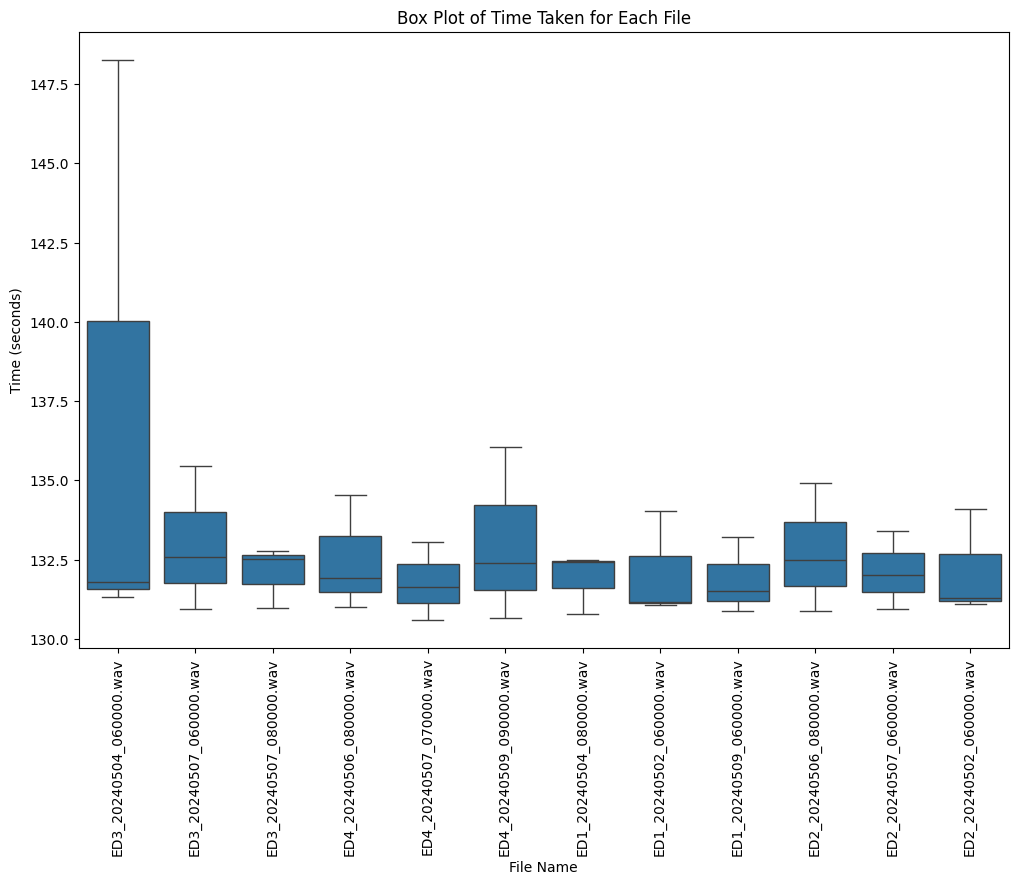

ANOVA results: F-statistic = 0.6128672382387197, p-value = 0.7999044174905225
There is no significant difference in the time taken between different files.


In [19]:

# Load the Data and Perform Analysis
# Load the timing data from the CSV file
df = pd.read_csv(csv_path)
print(df)

# Create Box Plots
plt.figure(figsize=(12, 8))
sns.boxplot(x='file_name', y='time', data=df)
plt.xticks(rotation=90)
plt.title('Box Plot of Time Taken for Each File')
plt.xlabel('File Name')
plt.ylabel('Time (seconds)')
plt.show()

# Perform ANOVA
# Group the times by file_name
grouped_times = [df[df['file_name'] == file_name]['time'].values for file_name in df['file_name'].unique()]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*grouped_times)

print(f"ANOVA results: F-statistic = {f_stat}, p-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in the time taken between different files.")
else:
    print("There is no significant difference in the time taken between different files.")
